<html>
<h1> Bergfex webscraping
</h1>
<body>We gather information about outdoor sport itineraries from <a href='https://www.bergfex.com/sommer/bern-region/touren/?isAjax=1&page=1'> Bergfex.com </a> in the region of Bern.<br />
    - The website displays 20 tours per page, with infos such as length, type of sport, rating, etc... <br />
    - Most informations are provided by users.<br />
<br />
We then clean the data, and do a bunch of simple analysis.
</body>
</html>

<html>
<h2> Part 1: Data scraping and cleaning
</h2>

</html>

In [17]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [18]:
# initializing the future colums of our dataframe with empty lists

title = []  # Title of the tour
difficulty = []  # difficulty (easy, medium, hard)
sport = []  # Sport type (hiking, sledging, snowshoe...)
length = []  # length in km
time = []  # tour time in hours:minutes
climb = []  # positive elevation climb in m
minmax = []  # minimum and maximum altitude of the tour in m
technique = []  # technique difficulty ratings (out of 6)
fitness = []  # fitness difficulty ratings (out of 6)
total_title = [] # will help extracting the ID of the tour

# all ratings are stored together so we will need this along the way:
rating = []  # list to store technique and fitness rating info

In [19]:
# looping over the 10 first pages of Bergfex
# each separate tour on the page is framed by a div tag with 'touren-details'

page_number = 20  # number of pages we want to scap through

for p in range(1, (page_number+1)):
    base_link = 'https://www.bergfex.com/sommer/bern-region/touren/?isAjax=1&page='
    link = base_link+str(p)  # going over p pages with numbers appended to the base link
    page = requests.get(link, timeout=5)
    print("scraped page", p)
    soup = BeautifulSoup(page.content, "html.parser")  # bs4.BeautifulSoup object
    tours = soup.findAll('div', {'class': 'touren-detail'})  # checks for the separate tours on the page

# For each page, we loop over each tour and fill our lists with info     
    for i in range(0,len(tours)):
        tour_1 = tours[i] # tour iterating over the 20 tours of the page

        tour_title = tour_1.findAll('a' ) # this gets the title out
        title.append([info.get_text().strip() for info in tour_title])
        total_title.append(tour_title) # this gets the full tourtitle information
        
        tour_diff = tour_1.findAll('span', {'class': 'tour-difficulty'}) #tour level difficulty
        difficulty.append([info.get_text().strip() for info in tour_diff])

        tour_type = tour_1.findAll('span', {'class': 'tour-type'}) # putting type into sports (should all be hiking)
        sport.append([info.get_text().strip() for info in tour_type])

        tour_stats = tour_1.findAll('div', {'class': 'tour-stats'}) # stats has 4 info binned together
        stat_text = [info.get_text().strip() for info in tour_stats]
        length.append(stat_text[0])
        time.append(stat_text[1])
        climb.append(stat_text[2])
        minmax.append(stat_text[3])
        
        tour_rating = tour_1.find_all("div", {'class': 'tour-rating'}) # getting the rating data 
        rating.append([info for info in tour_rating])   # it's a class name so we can't get_text.

scraped page 1
scraped page 2
scraped page 3
scraped page 4
scraped page 5
scraped page 6
scraped page 7
scraped page 8
scraped page 9
scraped page 10
scraped page 11
scraped page 12
scraped page 13
scraped page 14
scraped page 15
scraped page 16
scraped page 17
scraped page 18
scraped page 19
scraped page 20


In [20]:
print("number of tours collected:", len(title))

number of tours collected: 400


In [21]:
### Get the titles and IDs into a list and then a DF
links_title = []

for i in total_title:
    i = str(i)
    i = i.strip('[]')
    print(i)
    links_title.append(i)

id_df3 = pd.DataFrame(links_title)


<a class="h2" href="/sommer/bern-region/touren/wanderung/560728,burgenweg-in-wilderswil/" title="Burgenweg in Wilderswil">Burgenweg in Wilderswil</a>
<a class="h2" href="/sommer/bern-region/touren/schneeschuh/133933,chueematte-trail/" title="Chüematte Trail">Chüematte Trail</a>
<a class="h2" href="/sommer/bern-region/touren/trailrunning/309476,dem-wetterhorn-entgegen-nr-2/" title="Dem Wetterhorn entgegen Nr. 2">Dem Wetterhorn entgegen Nr. 2</a>
<a class="h2" href="/sommer/bern-region/touren/wanderung/278777,vom-rinderberg-ueber-den-truettlisbergpass-nach-lenk/" title="Vom Rinderberg über den Trüttlisbergpass nach Lenk">Vom Rinderberg über den Trüttlisbergpass nach Lenk</a>
<a class="h2" href="/sommer/bern-region/touren/schneeschuh/131734,lauenen--chrinepass--wispile/" title="Lauenen - Chrinepass - Wispile">Lauenen - Chrinepass - Wispile</a>
<a class="h2" href="/sommer/bern-region/touren/wanderung/733526,chasseral--der-abgeschiedene-huegelzug-hoch-ueber-dem-seeland/" title="Chasseral - 

In [22]:
### Strip out the ID --> in column ix 5 as 'str'
id_df2 = id_df3[0].str.split(' ',expand = True)
id_df1 = id_df2[2].str.split(',',expand = True)
id_df = id_df1[0].str.split('/',expand = True)
id_df[5][0]

## ---> id_df is holding the IDs

'560728'

In [23]:
# Dealing with the ratings for fitness and technique
# we need to extract Rating data which is "embedded" as a class name in the bs4.BeautifulSoup
rating[0]

[<div class="tour-rating">
 <div class="tour-rating-label">Technique</div>
 <div class="rating-circles rating-max6"><div class="rating-1"></div></div>
 </div>,
 <div class="tour-rating">
 <div class="tour-rating-label">Fitness</div>
 <div class="rating-circles rating-max6"><div class="rating-2"></div></div>
 </div>]

In [24]:
# converting into string
tour_rating_str = str(rating)

# taking out unnecessary info - each second rating is Technique or Fitness, starting with technique
rating_all_short = tour_rating_str.replace('<div class="tour-rating">\n<div class="tour-rating-label">Technique</div>\n<div class="rating-circles rating-max6"><div class="','').replace('<div class="tour-rating">\n<div class="tour-rating-label">Fitness</div>\n<div class="rating-circles rating-max6"><div class="','').replace('"></div></div>\n</div>',"")
rating_even_shorter = rating_all_short.replace('[','').replace(']','')


## splitting into lists
rating_list = rating_even_shorter.split(", ")

In [25]:
# filling the lists technique = [] and fitness = []  we defined in the beginning

for i in range(0,(len(rating_list))):
    if i == 0:
        technique.append(rating_list[i]) # first item goes into technique
    elif i % 2 == 0:
        technique.append(rating_list[i]) # then every second item as well
    else:
        fitness.append(rating_list[i]) # the other items go into fitness

In [26]:
# Forming a dataframe from our lists as columns:

hikes_df = pd.DataFrame(
    {'title': title,
     'difficulty': difficulty,
     'sport': sport,
     'length': length,
     'time': time,
     'climb': climb,
     'minmax': minmax,
     'technique': technique,
     'fitness': fitness
    })

In [27]:
#  First draft dataframe: brackets, units, minmax to separate
hikes_df

,title,difficulty,sport,length,time,climb,minmax,technique,fitness
0,[Burgenweg in Wilderswil],[easy],[Hiking],5.08km,01:45h,136hm,580 - 684m,rating-1,rating-2
1,[Chüematte Trail],[medium],[Snowshoe],10.45km,05:00h,560hm,"1,201 - 1,815m",rating-,rating-4
2,[Dem Wetterhorn entgegen Nr. 2],[easy],[Trailrunning],9.54km,01:52h,428hm,"986 - 1,350m",rating-2,rating-2
3,[Vom Rinderberg über den Trüttlisbergpass nach...,[medium],[Hiking],17.83km,05:45h,536hm,"1,689 - 2,079m",rating-3,rating-4
4,[Lauenen - Chrinepass - Wispile],[difficult],[Snowshoe],7.56km,04:00h,717hm,"1,235 - 1,938m",rating-5,rating-5
...,...,...,...,...,...,...,...,...,...
395,[Wanderung Büren a. A. – Altreu-Fähre],[easy],[Hiking],10.07km,02:25h,-,422 - 445m,rating-1,rating-2
396,[Children's Adventure Trail - Mürren],[easy],[Thematic route],2.48km,01:50h,10hm,"1,638 - 1,909m",rating-2,rating-2
397,[Panoramaweg Hasliberg],[easy],[Winter hiking],8.15km,03:00h,332hm,"981 - 1,217m",rating-1,rating-2
398,[Eriz Trail - Eriz],[medium],[Snowshoe],6.39km,03:20h,440hm,"1,023 - 1,468m",rating-2,rating-3


<html>
<h2> Part 2: Data cleaning
</h2>
<body></body>
</html>

In [28]:
# Converting the text columns to strings for easier handling later

hikes_df[['title', 'difficulty', 'sport']] = hikes_df[['title', 'difficulty', 'sport']].astype('str')

In [29]:
# Removing the brackets

hikes_df['title'] = hikes_df['title'].str.strip('[]')
hikes_df['difficulty'] = hikes_df['difficulty'].str.strip('[]')
hikes_df['sport'] = hikes_df['sport'].str.strip('[]')

In [30]:
# For some reason '' appear now, removing those as well

hikes_df['title'] = pd.Series(hikes_df['title']).str.replace("'", '')
hikes_df['difficulty'] = pd.Series(hikes_df['difficulty']).str.replace("'", '')
hikes_df['sport'] = pd.Series(hikes_df['sport']).str.replace("'", '')

In [31]:
# The "string-cleaned" dataframe
hikes_df

,title,difficulty,sport,length,time,climb,minmax,technique,fitness
0,Burgenweg in Wilderswil,easy,Hiking,5.08km,01:45h,136hm,580 - 684m,rating-1,rating-2
1,Chüematte Trail,medium,Snowshoe,10.45km,05:00h,560hm,"1,201 - 1,815m",rating-,rating-4
2,Dem Wetterhorn entgegen Nr. 2,easy,Trailrunning,9.54km,01:52h,428hm,"986 - 1,350m",rating-2,rating-2
3,Vom Rinderberg über den Trüttlisbergpass nach ...,medium,Hiking,17.83km,05:45h,536hm,"1,689 - 2,079m",rating-3,rating-4
4,Lauenen - Chrinepass - Wispile,difficult,Snowshoe,7.56km,04:00h,717hm,"1,235 - 1,938m",rating-5,rating-5
...,...,...,...,...,...,...,...,...,...
395,Wanderung Büren a. A. – Altreu-Fähre,easy,Hiking,10.07km,02:25h,-,422 - 445m,rating-1,rating-2
396,"""Childrens Adventure Trail - Mürren""",easy,Thematic route,2.48km,01:50h,10hm,"1,638 - 1,909m",rating-2,rating-2
397,Panoramaweg Hasliberg,easy,Winter hiking,8.15km,03:00h,332hm,"981 - 1,217m",rating-1,rating-2
398,Eriz Trail - Eriz,medium,Snowshoe,6.39km,03:20h,440hm,"1,023 - 1,468m",rating-2,rating-3


In [32]:
# getting rid of the units (they're always the same anyway)

hikes_df['length'] = pd.Series(hikes_df['length']).str.replace("km", '')
hikes_df['time'] = pd.Series(hikes_df['time']).str.replace("h", '')
hikes_df['climb'] = pd.Series(hikes_df['climb']).str.replace("hm", '')
hikes_df['minmax'] = pd.Series(hikes_df['minmax']).str.replace("m", '')

In [33]:
# making 2 columns out of the last one, and removing the old minmax column

hikes_df[['min','max']] = hikes_df['minmax'].str.split("-",expand=True)
hikes_df = hikes_df.drop(columns=['minmax'])

# moving the ratings back to the end
hikes_df = hikes_df[['title', 'difficulty', 'sport', 'length', 'time', 'climb', 'min', 'max', 'technique', 'fitness']]


In [34]:
# The clean dataframe in string format

hikes_df


,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,Burgenweg in Wilderswil,easy,Hiking,5.08,01:45,136,580,684,rating-1,rating-2
1,Chüematte Trail,medium,Snowshoe,10.45,05:00,560,"1,201","1,815",rating-,rating-4
2,Dem Wetterhorn entgegen Nr. 2,easy,Trailrunning,9.54,01:52,428,986,"1,350",rating-2,rating-2
3,Vom Rinderberg über den Trüttlisbergpass nach ...,medium,Hiking,17.83,05:45,536,"1,689","2,079",rating-3,rating-4
4,Lauenen - Chrinepass - Wispile,difficult,Snowshoe,7.56,04:00,717,"1,235","1,938",rating-5,rating-5
...,...,...,...,...,...,...,...,...,...,...
395,Wanderung Büren a. A. – Altreu-Fähre,easy,Hiking,10.07,02:25,-,422,445,rating-1,rating-2
396,"""Childrens Adventure Trail - Mürren""",easy,Thematic route,2.48,01:50,10,"1,638","1,909",rating-2,rating-2
397,Panoramaweg Hasliberg,easy,Winter hiking,8.15,03:00,332,981,"1,217",rating-1,rating-2
398,Eriz Trail - Eriz,medium,Snowshoe,6.39,03:20,440,"1,023","1,468",rating-2,rating-3


In [35]:
# converting to number data types:

# length
hikes_df['length'] = (hikes_df['length']).astype(float)

# Climb
# to handle the conversions we replace missing values by 0. Maybe nan would work too, but didn't find out how yet
hikes_df['climb'] = pd.Series(hikes_df['climb']).str.replace(",", '') # replace thousand separator
hikes_df['climb'] = pd.Series(hikes_df['climb']).str.replace("-", '0') # replaces - by 0
hikes_df['climb'] = (hikes_df['climb']).astype(int)


In [36]:
#min and max
hikes_df['min'] = pd.Series(hikes_df['min']).str.replace(",", '') # replace thousand separator
hikes_df['min'] = (hikes_df['min']).astype(int)
hikes_df['max'] = pd.Series(hikes_df['max']).str.replace(",", '') # replace thousand separator
hikes_df['max'] = (hikes_df['max']).astype(int)

In [37]:
# dropping activities that are longer than 24 hrs
#### Watchout - only run once!!??

filt = hikes_df[(hikes_df['time'] > '24:00')]
filt

index_todrop = hikes_df.index[hikes_df['time'] > '24:00'].tolist()

hikes_df = hikes_df.drop(index_todrop)
#len(hikes_df)
hikes_df

,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,Burgenweg in Wilderswil,easy,Hiking,5.08,01:45,136,580,684,rating-1,rating-2
1,Chüematte Trail,medium,Snowshoe,10.45,05:00,560,1201,1815,rating-,rating-4
2,Dem Wetterhorn entgegen Nr. 2,easy,Trailrunning,9.54,01:52,428,986,1350,rating-2,rating-2
3,Vom Rinderberg über den Trüttlisbergpass nach ...,medium,Hiking,17.83,05:45,536,1689,2079,rating-3,rating-4
4,Lauenen - Chrinepass - Wispile,difficult,Snowshoe,7.56,04:00,717,1235,1938,rating-5,rating-5
...,...,...,...,...,...,...,...,...,...,...
395,Wanderung Büren a. A. – Altreu-Fähre,easy,Hiking,10.07,02:25,0,422,445,rating-1,rating-2
396,"""Childrens Adventure Trail - Mürren""",easy,Thematic route,2.48,01:50,10,1638,1909,rating-2,rating-2
397,Panoramaweg Hasliberg,easy,Winter hiking,8.15,03:00,332,981,1217,rating-1,rating-2
398,Eriz Trail - Eriz,medium,Snowshoe,6.39,03:20,440,1023,1468,rating-2,rating-3


In [38]:
# converting times to time objects

# pandas datetime doesn't handle times over 24 hours so we have to give him an alternative
try:
    hikes_df['time'] = pd.to_datetime(hikes_df['time'], format='%H:%M').dt.time
except ValueError:
    pass
# I want to get rid of seconds but it's bed time


In [39]:
type(hikes_df['technique'][0])

str

In [40]:
## rating technique
hikes_df['technique'] = pd.Series(hikes_df['technique']).str.replace("rating-", '')
hikes_df['technique'] = pd.to_numeric(hikes_df['technique'], errors='coerce')
hikes_df['technique'] = pd.Series(hikes_df['technique']).replace(np.nan, 0, regex = True)
hikes_df['technique'] = pd.Series(hikes_df['technique']).astype('int')

# rating fitness
hikes_df['fitness'] = pd.Series(hikes_df['fitness']).str.replace("rating-", '')
hikes_df['fitness'] = pd.to_numeric(hikes_df['fitness'], errors='coerce')
hikes_df['fitness'] = pd.Series(hikes_df['fitness']).replace(np.nan, 0, regex = True)
hikes_df['fitness'] = hikes_df['fitness'].astype('int')

In [41]:
# Finally the clean dataframe 

hikes_df

,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,Burgenweg in Wilderswil,easy,Hiking,5.08,01:45:00,136,580,684,1,2
1,Chüematte Trail,medium,Snowshoe,10.45,05:00:00,560,1201,1815,0,4
2,Dem Wetterhorn entgegen Nr. 2,easy,Trailrunning,9.54,01:52:00,428,986,1350,2,2
3,Vom Rinderberg über den Trüttlisbergpass nach ...,medium,Hiking,17.83,05:45:00,536,1689,2079,3,4
4,Lauenen - Chrinepass - Wispile,difficult,Snowshoe,7.56,04:00:00,717,1235,1938,5,5
...,...,...,...,...,...,...,...,...,...,...
395,Wanderung Büren a. A. – Altreu-Fähre,easy,Hiking,10.07,02:25:00,0,422,445,1,2
396,"""Childrens Adventure Trail - Mürren""",easy,Thematic route,2.48,01:50:00,10,1638,1909,2,2
397,Panoramaweg Hasliberg,easy,Winter hiking,8.15,03:00:00,332,981,1217,1,2
398,Eriz Trail - Eriz,medium,Snowshoe,6.39,03:20:00,440,1023,1468,2,3


In [42]:
# the dataframe info sum up yay we managed!
hikes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       400 non-null    object 
 1   difficulty  400 non-null    object 
 2   sport       400 non-null    object 
 3   length      400 non-null    float64
 4   time        400 non-null    object 
 5   climb       400 non-null    int64  
 6   min         400 non-null    int64  
 7   max         400 non-null    int64  
 8   technique   400 non-null    int64  
 9   fitness     400 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 54.4+ KB


#### <html>
<h2> Part 3: Downloading GeoData for the hikes
</h2>
<body>to create the for loop for all the 400 hikes</body>
</html>

In [43]:
### Imports
import requests
import re
from pykml import parser
from lxml import etree
from lxml import objectify

#### <html> 
<h3> Download the KML file
    </h3>
<body>We do this by parsing the url, and then converting into the the kml link that is used on the website.

- https://www.bergfex.com/downloads/gps/?type=&id=271548&fileType=kml
- Get file name from the url
    </body>
</html>

In [44]:
kml_link = ""
url = "https://www.bergfex.com/downloads/gps/"
url3= "https://www.bergfex.com/downloads/gps/?type=&amp;id=271548&amp;fileType=kml"
if url3.find('/'):
    print(url3.rsplit('/', 1)[1])
    kml_link = (url3.rsplit('/', 1)[1])
    new_s = kml_link.replace('=&amp;', '=&')
    print(new_s)

conc_kml_link = (url + new_s)
print(conc_kml_link )

?type=&amp;id=271548&amp;fileType=kml
?type=&id=271548&amp;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=271548&amp;fileType=kml


#### <html> 
<h3>Write the data to a klm file locally
    </h3>
<body> 
- TO DO:
- This will be the file that we need to write our data from, and then add it to a data frame
    </body>
    </html>

In [9]:
r = requests.get(conc_kml_link, allow_redirects=True)
write_link = ( new_s + ".klm")
write_link
open(write_link, 'wb').write(r.content)

14653

#### <html> 
<h3>Create loop to download all entries
    </h3>
    <body> DONE </body>

In [45]:
## get list of all IDs
final_id = id_df.iloc[:,5]
final_id

0      560728
1      133933
2      309476
3      278777
4      131734
        ...  
395     81772
396     75407
397    157787
398     52070
399    509595
Name: 5, Length: 400, dtype: object

In [46]:
test_loop = final_id.iloc[0:3]
test_loop

0    560728
1    133933
2    309476
Name: 5, dtype: object

In [47]:
## For loop to create: i) all kml files (400 items) --> take 'final_id', ii) for testing --> take 'test_loop'
## Saves the files in same directory as the notebook

for sport_id in test_loop: 
    url_id = f"https://www.bergfex.com/downloads/gps/?type=&amp;id='{sport_id}&amp;fileType=kml"
    print(url_id)
    r = requests.get(url_id, allow_redirects=True)
    write_link = (sport_id + ".klm")
    open(write_link, 'wb').write(r.content)

write_link


https://www.bergfex.com/downloads/gps/?type=&amp;id='560728&amp;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&amp;id='133933&amp;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&amp;id='309476&amp;fileType=kml


'309476.klm'

#### <html> 
<h3> Read out the first postion of each file and add to DF
    </h3>

<body> Still to do </body>

#### <html>
<h2> Part 4: Get snow data
</h2>
<body>DONE</body>
</html>

In [33]:
### all the imports

import requests
import re
from bs4 import BeautifulSoup
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [34]:
### initializing the future colums of our dataframe with empty lists

snowlevel = []  # height in cm
location = []  # town and elevation of town

## no looping over several pages necessary

## only scrape first page
link = 'http://www.meteocentrale.ch/de/wetter/hitlisten/schneehoehen.html'
page = requests.get(link, timeout=10)
print(page.status_code)
soup = BeautifulSoup(page.content, "html.parser")  # bs4.BeautifulSoup object
hitlist = soup.findAll('table', {'class': 'hitlist'})  #bs4.element.ResultSet

200


In [35]:
## get location
location_item = hitlist[0].findAll('a')
location.append([info.get_text().strip() for info in location_item])
loc = location[0]
#len(loc)
#loc

## get snowlevel
snowlevel_item = hitlist[0].findAll('td', {'class': 'value'}) #
snowlevel.append([info.get_text().strip() for info in snowlevel_item])
#len(snowlevel)
snow = snowlevel[0]
#len(snow)
#snow


## combine into DF
heights_df = pd.DataFrame({'location': loc,'snowlevel': snow})
heights_df

,location,snowlevel
0,"Gornergrat, 3130 m",41 cm
1,"Glattalp, 1858 m",16 cm
2,"Chuenisbaergli-Schneehoehe, 0 m",3 cm
3,"Lenzerheide, 1484 m",3 cm
4,"Corviglia, 2497 m",2 cm
...,...,...
61,"Wiler (Lötschen), 1415 m",0 cm
62,"Zermatt, 1638 m",0 cm
63,"Zollikofen, 553 m",0 cm
64,"Zürich-Affoltern, 443 m",0 cm


In [36]:
### data manipulation: 

##remove cm, convert to 'int'
heights_df['snowlevel_in_cm']=pd.Series(heights_df['snowlevel']).str.replace(" cm", '')
heights_df['snowlevel_in_cm']=pd.Series(heights_df['snowlevel_in_cm']).astype(int)
#type(heights_df['snowlevel_in_cm'][0])
#heights_df

## split location into 'village' and 'elevation of village' and merge with previous DF
split_loc = pd.Series(heights_df['location']).str.split(',',n=2,expand = True)
merged_df = pd.merge(heights_df, split_loc, left_index=True, right_index=True)
#merged_df

## drop unused columns, rename final columns, remove unit, sort columns
intermediate_df1 = merged_df.iloc[:,[2,3,4]]
intermediate_df1.columns = ['snowlevel_in_cm', 'location', 'height_in_m']
intermediate_df1['height_in_m']=pd.Series(intermediate_df1['height_in_m']).str.replace(" m", '')
intermediate_df2 = pd.DataFrame(intermediate_df1, columns = ['location', 'height_in_m', 'snowlevel_in_cm'])



<ipython-input-36-b1b349985263>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intermediate_df1['height_in_m']=pd.Series(intermediate_df1['height_in_m']).str.replace(" m", '')


In [37]:
### final dataframe

intermediate_df2

,location,height_in_m,snowlevel_in_cm
0,Gornergrat,3130,41
1,Glattalp,1858,16
2,Chuenisbaergli-Schneehoehe,0,3
3,Lenzerheide,1484,3
4,Corviglia,2497,2
...,...,...,...
61,Wiler (Lötschen),1415,0
62,Zermatt,1638,0
63,Zollikofen,553,0
64,Zürich-Affoltern,443,0


In [38]:
### Export into csv

#intermediate_df2.to_csv(r'/Users/sd/Documents/0-Coding/sarah-dutschke/04-Visualization/Challenge/snow_level.csv', index = False)

#### <html>
<h2> Part 5: Data analysis 
</h2>
<body>(just to check the dataframe actually works)</body>
</html>

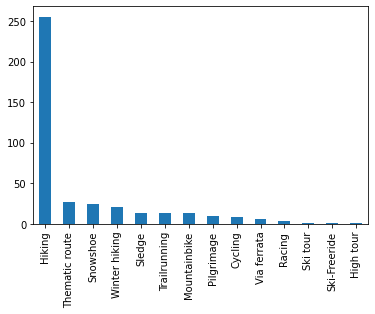

In [39]:
# Number of entries by types of sports
hikes_df['sport'].value_counts().plot(kind='bar')

In [40]:
# Creating a df for "Number of entries by sport type" + average tour length

sporttype = hikes_df.groupby('sport') \
       .agg({'sport':'count', 'length':'mean'}) \
       .rename(columns={'sport':'count','length':'average_length'}) \
       .reset_index()
sporttype

,sport,count,average_length
0,Cycling,9,34.477778
1,High tour,1,18.370000
2,Hiking,255,10.967137
3,Mountainbike,13,31.871538
4,Pilgrimage,10,17.848000
5,Racing,4,82.585000
6,Ski tour,1,6.110000
7,Ski-Freeride,1,7.970000
8,Sledge,14,5.280714
9,Snowshoe,24,6.244583


In [41]:
# Difficulty

hikes_df['difficulty'].unique()

array(['difficult', 'medium', '', 'easy'], dtype=object)

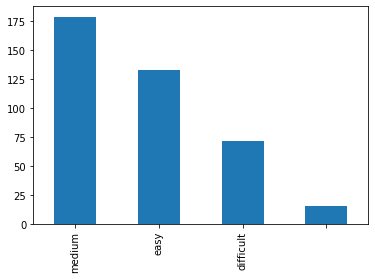

In [42]:
hikes_df['difficulty'].value_counts().plot(kind='bar')

In [43]:
# mean length for difficulty:

hikes_df.groupby('difficulty').mean()

,length,climb,min,max,technique,fitness
difficulty,,,,,,
,10.708667,414.533333,858.133333,1269.400000,0.000000,0.000000
difficult,21.464444,1088.833333,1040.944444,2036.680556,3.250000,4.972222
easy,7.772707,173.300752,919.436090,1132.045113,1.278195,1.827068
medium,11.619106,530.770950,1115.826816,1679.251397,2.486034,3.307263


Text(0.5, 1.0, 'All activities')

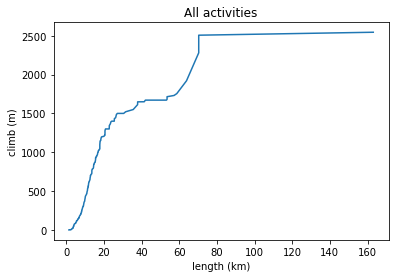

In [44]:
#df.reset_index().plot.scatter(x = 'index', y = 'value')
tour_len = sorted(pd.Series(hikes_df["length"]))
tour_climb = sorted(pd.Series(hikes_df["climb"]))
plt.plot(tour_len, tour_climb)
plt.ylabel('climb (m)')
plt.xlabel("length (km)")
plt.title('All activities')

In [45]:
## Creating a df for deeper analysis for Hiking
# Filter for hiking
hiking = hikes_df[hikes_df.sport == "Hiking"]

# calculating the count by Fitness level and the average length 
fitness_length = hiking.groupby('fitness') \
       .agg({'fitness':'count', 'length':'mean'}) \
       .rename(columns={'fitness':'count','length':'average_length'}) \
       .reset_index()

# calculating weighted and normalized length
fitness_length['weighted_ave_length'] = fitness_length["count"] * fitness_length["average_length"]
fitness_length["normalized_weighted_length"] = (fitness_length["weighted_ave_length"] - fitness_length["weighted_ave_length"].min()) \
                                                / (fitness_length["weighted_ave_length"].max() - fitness_length["weighted_ave_length"].min()) * 10
fitness_length


,fitness,count,average_length,weighted_ave_length,normalized_weighted_length
0,0,15,10.708667,160.63,1.134035
1,1,14,6.192857,86.70,0.000000
2,2,72,8.274306,595.75,7.808473
3,3,62,9.955000,617.21,8.137655
4,4,54,13.678148,738.62,10.000000
5,5,30,14.805333,444.16,5.483188
6,6,8,19.193750,153.55,1.025433


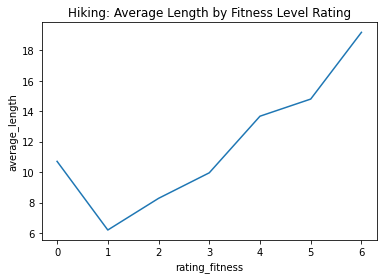

In [46]:
## Plotting Length vs. Fitness rating
#--> Conclusion: the routes with no fitness rating seems quite long. Investigate further

plt.plot(fitness_length["fitness"], fitness_length["average_length"])
plt.ylabel('average_length')
plt.xlabel("rating_fitness")
plt.title('Hiking: Average Length by Fitness Level Rating')

plt.show()

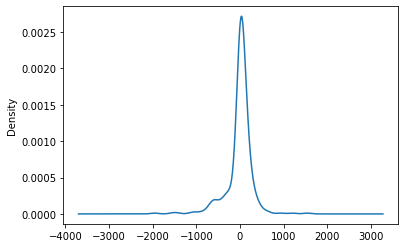

In [47]:
# quality checking data / or realizing we don't understand the columns?

hikes_df["residual"]= hikes_df["climb"] - (hikes_df["max"] - hikes_df["min"])
hikes_df["residual"].plot.density()

#### <html>
<h2> Part 6: Dashboard
</h2>
<body>(pretty much a lot to do stil :-))</body>
</html>

In [48]:
### import Dashboard libraries

# bokeh
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, CDSView, HoverTool, Range1d,GroupFilter
from bokeh.io import output_notebook
from bokeh.palettes import Dark2_8, magma
from bokeh.models import Legend, LegendItem
import itertools

# Panel as well
import panel as pn

pn.extension()
output_notebook()

Loading BokehJS ...

In [49]:
## Prepare the x/y axis for elevation graph

## x_axis made out of time duration
x = []
for n in hikes_df['time']:
    x.append(n)
xs = [[0,n] for n in x]

## y_axis made out of min and max altitude
y1 = []
y2 = []
for min_, max_ in zip(hikes_df['min'], hikes_df['max']):
    y1.append(min_)
    y2.append(max_)
ys = [[min_, max_] for min_, max_ in zip(hikes_df['min'], hikes_df['max'])]

#ys
#len(ys)
#xs
len(xs)

399

In [50]:
## Add to DataFrame

hikes_df['ys'] = ys
hikes_df['xs'] = xs
#type(hikes_df['time'][0])

In [57]:
### Preparing the plots

## Create a ColumnDataSource
main_cds = ColumnDataSource(hikes_df)

## Create the views for each difficulty level
easy_view = CDSView(source = main_cds, filters=[GroupFilter(column_name='difficulty', group = 'easy')])
medium_view = CDSView(source = main_cds,filters=[GroupFilter(column_name='difficulty', group = 'medium')])
difficult_view = CDSView(source = main_cds,filters=[GroupFilter(column_name='difficulty',group = 'difficult')])

## Create and configure the figure
easy_fig = figure(x_range=[0,hikes_df['time'].max()], 
                  y_range=(hikes_df['min'].min()-100,hikes_df['max'].max()+100), 
                plot_width= 400, plot_height=300,
                 x_axis_label = "Length in hrs",
                 y_axis_label = 'Altitude: from start to highest point',
                 toolbar_location = None)

#line_color = magma(201)

## Fill the figures
easy_fig.multi_line('xs', 'ys', color = 'firebrick', alpha = 0.5, line_width=1, source = main_cds, view = easy_view)

## Remaining aestetics
#easy_fig.legend.location = 'below'

show(easy_fig)

In [52]:
type(hikes_df['length'][0])

numpy.float64